## **DSN 2024 BOOTCAMP QUALIFICATION HACKATHON PROJECT**


<img style="display: block; margin: 0 auto;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTmHNp5ox0u3HNMQZ_UMN8OicEwGuV6AqHkHQ&s" width="1000" height="200"/>

## **PROBLEM STATEMENT**

> A `heart attack (Cardiovascular diseases)` occurs when the flow of blood to the heart muscle suddenly becomes blocked. From WHO statistics every year `17.9 million` dying from heart attack. The medical study says that human life style is the main reason behind this heart problem. Apart from this there are many key factors which warns that the person may/maynot getting chance of heart attack.

<img style="display: block; margin: 0 auto;" src="https://img.lovepik.com/photo/50074/6189.jpg_wh860.jpg" width="1200" height="300"/>

> The challenge at hand revolves around the creation of a `predictive model` aimed at determining the likelihood of an individual having heart disease. As one of the leading causes of global mortality, detecting heart disease in its early stages is pivotal for enhancing patient outcomes and halting its progression. The conventional diagnostic methods often come with substantial costs and time requirements. Thus, there exists a pressing need for a cutting-edge predictive model that can evaluate the risk of heart disease utilizing easily accessible patient information.

> The `objective` of this challenge is to design and build a predictive model capable of accurately determining the probability of an individual having heart disease.

## **Table of Contents**



1.   Environment setup and Packages Installation
2.   Libraries, Configurations and Utilities
3.   Exploratory Data Analysis (EDA)
4.   Feature Engineering
5.   Hyperparameter Tuning and Feature Selection
6.   Ensembling
7.   Conclusion

## **1. Environment setup and Packages Installation**

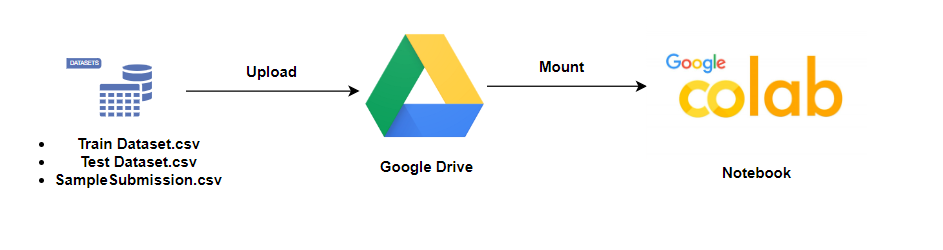

**Mounting google drive**

In [ ]:
## Connecting Drive to Google Colab for dataset access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Packages Installation**

In [ ]:
%%capture
!pip install catboost==1.2.7
!pip install xgboost==2.1.1
!pip install lightgbm==4.5.0
!pip install sklearn==1.5.2
!pip install optuna==4.0.0

## **2. Libraries, Configurations and Utilities**

**Libraries**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

**CONFIG**

In [ ]:
class CFG:
    base_path = "/content/drive/MyDrive/ZindiCompetition/DSNHack/"
    random_state = 2024

**UTILS**

In [ ]:
def feature_engineering(df):
    # BMI (Body Mass Index) approximation
    df['bmi'] = df['chol'] / (df['age'] ** 2)

    # Age groups
    df['age_group'] = pd.cut(df['age'], bins=[0, 40, 60, 80, 100], labels=[0, 1, 2, 3])

    # Blood Pressure categories
    df['bp_category'] = pd.cut(df['trestbps'], bins=[0, 120, 140, 180, 300], labels=[0, 1, 2, 3])

    # Heart Rate Reserve (HRR) approximation
    df['hrr'] = 220 - df['age'] - df['thalach']

    # Interaction features
    df['age_chol'] = df['age'] * df['chol']
    df['trestbps_chol'] = df['trestbps'] * df['chol']

    # Polynomial features for key numerical columns
    for col in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']:
        df[f'{col}_squared'] = df[col] ** 2

    return df

## **3. Exploratory Data Analysis (EDA)**

**DATASET**

In [ ]:
train = pd.read_csv(CFG.base_path + "Train Dataset .csv")
test = pd.read_csv(CFG.base_path + "Test Dataset.csv")
sample_submission = pd.read_csv(CFG.base_path + "Sample Submission.csv")

train.columns = ['id', 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
test.columns = ['id', 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

**Data Exploration**

In [ ]:
train.head()

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,16167,33,0,1,158,205,1,0,154,0,1.5,1,4,1,1
1,11275,53,1,2,198,154,0,1,104,0,0.8,2,1,0,0
2,13251,37,1,2,101,202,1,0,155,0,2.1,1,3,1,1
3,19921,75,0,0,113,306,1,2,88,1,4.9,0,2,2,1
4,11293,35,1,2,139,419,1,1,166,1,0.9,2,4,0,1


In [ ]:
test.head()

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,16501,70,1,0,163,495,0,2,170,1,2.0,1,0,1
1,10444,61,1,0,131,238,0,2,74,1,4.9,2,2,2
2,14288,53,1,0,95,558,1,1,73,1,0.7,1,1,0
3,10409,37,0,1,178,287,0,1,192,1,5.7,1,0,0
4,17330,35,0,3,104,281,0,0,122,0,1.3,1,4,3


,id,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,16501,70,1,0,163,495,0,2,170,1,2.0,1,0,1
1,10444,61,1,0,131,238,0,2,74,1,4.9,2,2,2
2,14288,53,1,0,95,558,1,1,73,1,0.7,1,1,0
6,13447,30,0,0,161,466,0,0,202,0,3.1,0,3,1
7,16464,70,1,0,195,126,0,0,135,0,0.3,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2684,19116,65,1,0,160,141,1,0,92,0,5.0,1,1,1
2689,17373,62,1,0,178,475,1,1,145,0,5.1,1,1,1
2690,18744,42,0,0,128,362,0,0,77,0,3.6,2,4,0
2694,18884,31,1,0,153,457,1,1,170,1,3.8,0,3,1


## **PLOTS**

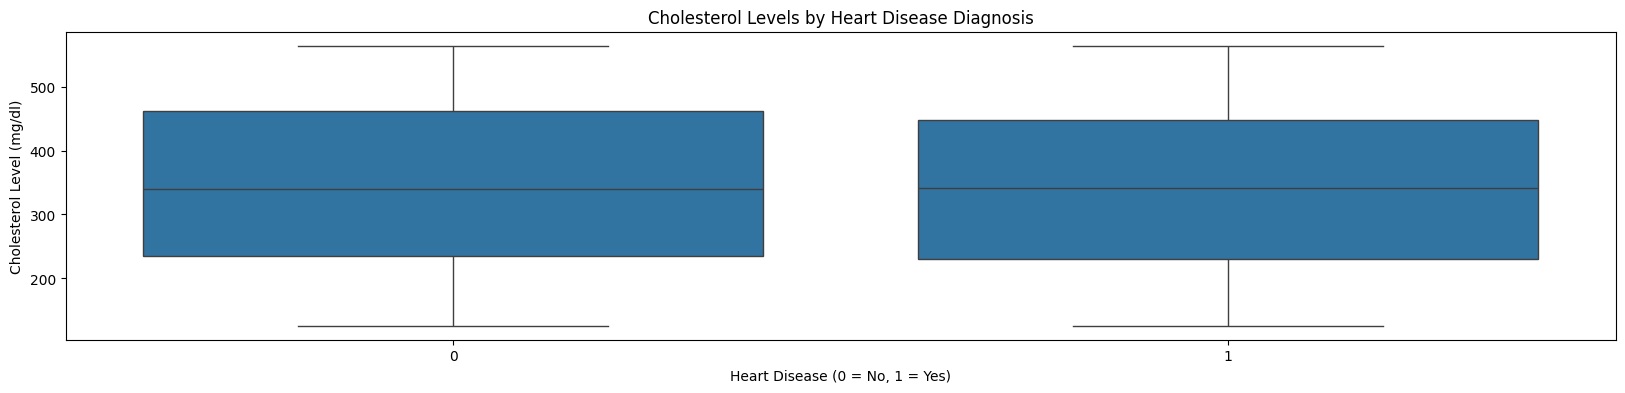

In [ ]:
plt.figure(figsize=(20, 4))
sns.boxplot(x='target', y='chol', data=train)
plt.title('Cholesterol Levels by Heart Disease Diagnosis')
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Cholesterol Level (mg/dl)')
plt.show()

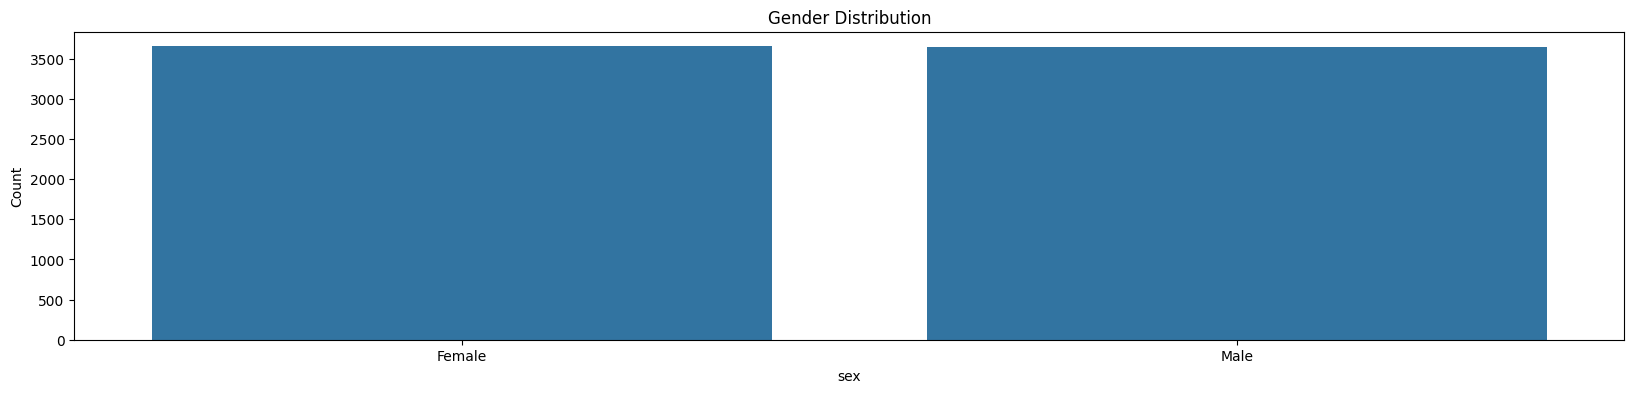

In [ ]:
plt.figure(figsize=(20, 4))
sns.countplot(x='sex', data=train)
plt.title('Gender Distribution')
plt.xticks([0, 1], ['Female', 'Male'])
plt.ylabel('Count')
plt.show()

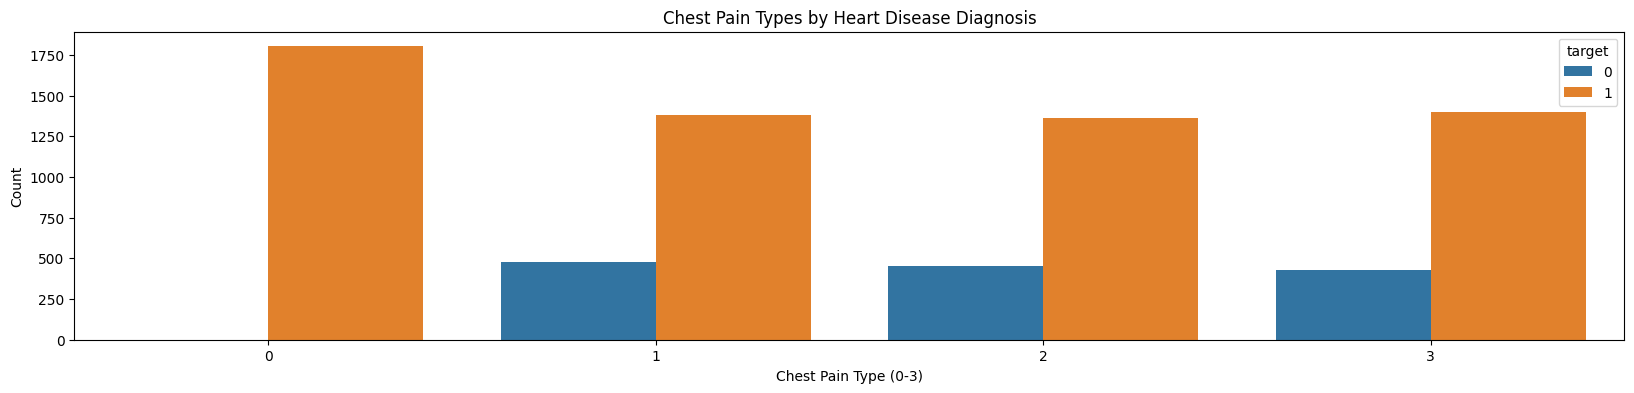

In [ ]:
plt.figure(figsize=(20, 4))
sns.countplot(x='cp', hue='target', data=train)
plt.title('Chest Pain Types by Heart Disease Diagnosis')
plt.xlabel('Chest Pain Type (0-3)')
plt.ylabel('Count')
plt.show()

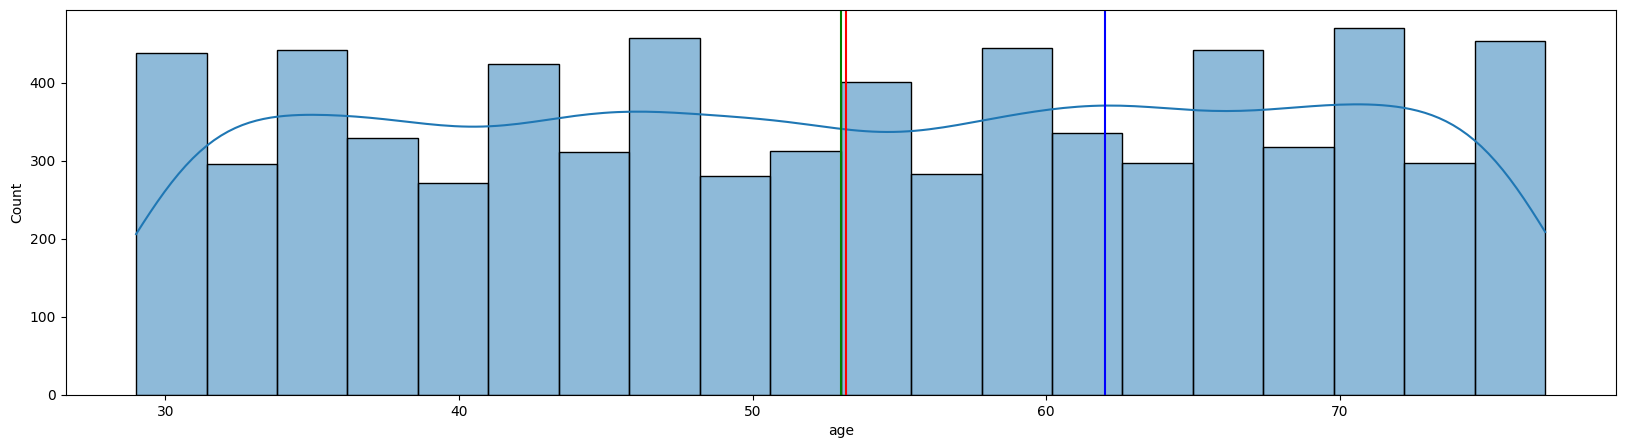

In [ ]:
# Plot the mean, Median and mode of age column using sns
plt.figure(figsize=(20, 5))
sns.histplot(train['age'], kde=True)
plt.axvline(train['age'].mean(), color='Red')
plt.axvline(train['age'].median(), color= 'Green')
plt.axvline(train['age'].mode()[0], color='Blue')

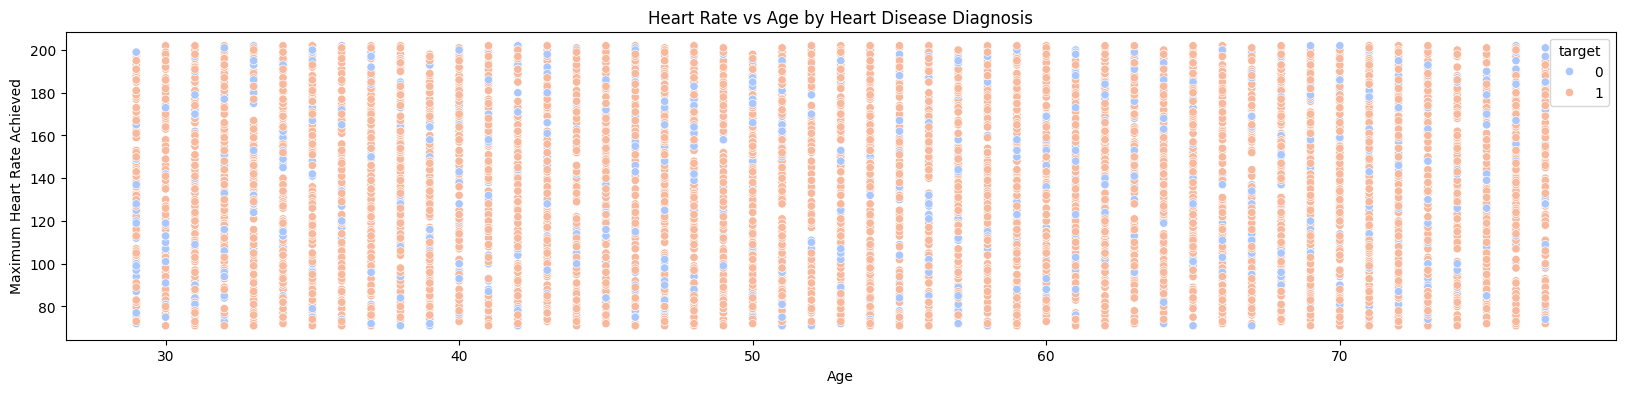

In [ ]:
plt.figure(figsize=(20, 4))
sns.scatterplot(x='age', y='thalach', hue='target', data=train, palette='coolwarm')
plt.title('Heart Rate vs Age by Heart Disease Diagnosis')
plt.xlabel('Age')
plt.ylabel('Maximum Heart Rate Achieved')
plt.show()

## **4. Feature Engineering**

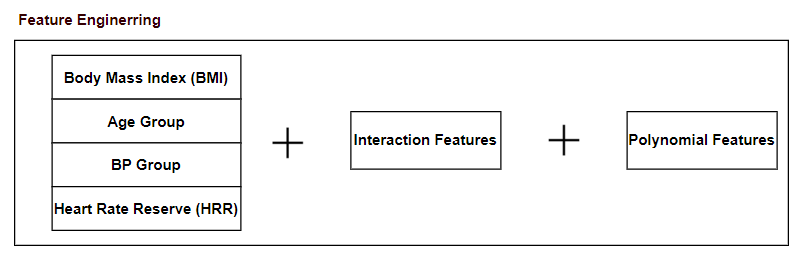

In [ ]:
features = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

train_features = train[features]
test_features = test[features]

# # Apply feature engineering to both train and test sets
train_features = feature_engineering(train_features)
test_features = feature_engineering(test_features)

# Update the features list
features = train_features.columns.tolist()

target = train['target']

In [ ]:
train_features.shape

(7303, 24)

## **5. Hyperparameter Tuning and Feature Selection**

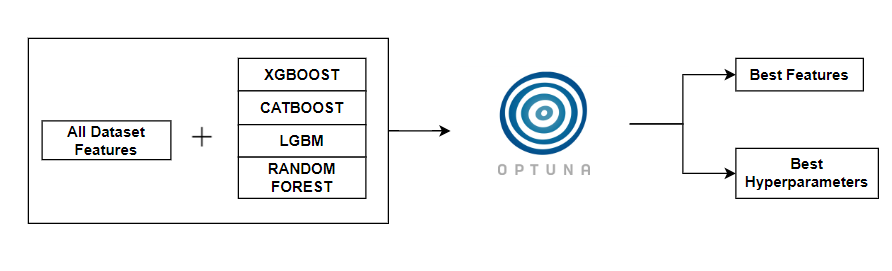

**CATBOOST MODELS TUNING**

In [ ]:
# X_train, X_test, Y_train, Y_test = train_test_split(train_features, target, test_size = 0.3,
#                                                     random_state = CFG.random_state, stratify=target)

In [ ]:
# # Define the objective function
# def objective(trial):
#     # Define the hyperparameter search space for feature selection (binary for each feature)
#     selected_features = []
#     for i in range(X_train.shape[1]):
#         selected = trial.suggest_categorical(f'feature_{i}', [0, 1])  # 0: exclude, 1: include
#         if selected == 1:
#             selected_features.append(X_train.columns[i])

#     # Ensure at least one feature is selected
#     if len(selected_features) == 0:
#         return 0.0

#     # Subset the dataset with selected features
#     X_train_selected = X_train[selected_features]
#     X_test_selected = X_test[selected_features]

#     # Get categorical features (e.g., features with dtype 'category')
#     cat_features = [col for col in X_test_selected.columns if str(X_test_selected[col].dtype) == 'category']

#     class_weights = {0: 1.0, 1: (len(Y_train) / Y_train.sum())}  # Adjust class weights as needed

#     # Define the hyperparameter search space for CatBoostClassifier
#     # Include class_weights in the params for CatBoostClassifier
#     params = {
#         'iterations': trial.suggest_int('iterations', 100, 1000),
#         'depth': trial.suggest_int('depth', 3, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 100),
#         'random_strength': trial.suggest_float('random_strength', 1e-9, 10),
#         'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
#         'random_seed': CFG.random_state,
#         'verbose': False,
#     }

#     # Initialize the model with the selected hyperparameters
#     model = CatBoostClassifier(**params)

#     # Train the model
#     model.fit(X_train_selected, Y_train, cat_features=cat_features)

#     # Make predictions
#     y_pred = model.predict(X_test_selected)

#     # Evaluate the performance (you can change to another metric like AUC or ROC if needed)
#     return accuracy_score(Y_test, y_pred)

In [ ]:
# # Create a study object and specify the direction as 'maximize' for accuracy
# study = optuna.create_study(direction='maximize')

# # Optimize the objective function with 10000 trials
# study.optimize(objective, n_trials=10000)

In [ ]:
# # Get the best parameters and the best set of selected features
# best_params = study.best_params
# print("Best parameters found: ", best_params)

In [ ]:
# # Extract selected features
# best_features = [col for i, col in enumerate(train_features.columns) if best_params[f'feature_{i}'] == 1]
# print("Selected features: ", best_features)

## **6. Modelling and Ensembling**


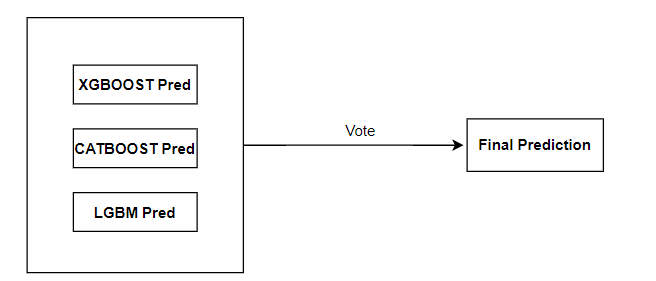

**Catboost Model 1**

In [ ]:
class_weights = {0: 1.0, 1: (len(target) / target.sum())}  # Adjust imbalance
cat_features = [col for col in train_features.columns if str(train_features[col].dtype) == 'category']

In [ ]:
catboost_features_1 = ['sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'exang', 'bmi',
                          'bp_category', 'trestbps_chol', 'age_squared', 'chol_squared', 'thalach_squared']

catboost_params_1 =  {'iterations': 810, 'depth': 10, 'learning_rate': 0.26407903520645837, 'l2_leaf_reg': 68.21495529151917,
 'random_strength': 7.790989105309213, 'bagging_temperature': 0.594834586206981, 'random_seed': 42,
        'verbose': False, 'class_weights': class_weights}

categorical_1 = [x for x in cat_features if x in catboost_features_1]

catboost_model_1 = CatBoostClassifier(**catboost_params_1, cat_features=categorical_1)
catboost_model_1.fit(train_features[catboost_features_1], target)

prediction_catboost_1 =catboost_model_1.predict(test_features[catboost_features_1])

**Catboost Model 2**

In [ ]:
catboost_features_2 = ['cp', 'fbs', 'thalach', 'exang', 'ca', 'thal',
                       'bp_category', 'age_chol', 'chol_squared', 'oldpeak_squared']

catboost_params_2 =  {'iterations': 541, 'depth': 3, 'learning_rate': 0.2318062639689416, 'l2_leaf_reg': 16.00995304481649,
 'random_strength': 6.120843268972148, 'bagging_temperature': 0.8221047212805065,'random_seed': 2024,
        'verbose': False}

categorical_2 = [x for x in cat_features if x in catboost_features_2]

catboost_model_2 = CatBoostClassifier(**catboost_params_2, cat_features=categorical_2)
catboost_model_2.fit(train_features[catboost_features_2], target)

prediction_catboost_2 = catboost_model_2.predict(test_features[catboost_features_2])

**XGBoost Model 1**

In [ ]:
xgboost_params = {'n_estimators': 242, 'max_depth': 3,
          'learning_rate': 0.2834465941882216, 'subsample': 0.9556026928296188,
          'colsample_bytree': 0.9731562298439886, 'gamma': 0.0023759864466612185}

xgboost_features = ['age', 'sex', 'cp', 'trestbps', 'restecg', 'thalach', 'exang', 'ca',
                    'thal', 'age_chol', 'chol_squared', 'thalach_squared']

xgboost_model = XGBClassifier(**xgboost_params, random_state = 2024)

xgboost_model.fit(train_features[xgboost_features], target)

prediction_xgboost = xgboost_model.predict(test_features[xgboost_features])

**LGBM Model 1**

In [ ]:
params_lgb_1 = {'n_estimators': 683, 'max_depth': 7, 'learning_rate': 0.28293924897412237,
              'subsample': 0.6457733642594046, 'colsample_bytree': 0.693223059685016,
              'reg_alpha': 0.10679074068525181}

features_lgb_1 =  ['cp', 'fbs', 'exang', 'oldpeak', 'bmi', 'age_group', 'age_chol',
                   'age_squared', 'chol_squared', 'oldpeak_squared']

model_lgb_1 = LGBMClassifier(**params_lgb_1, random_state = 2024, verbosity=-1)

model_lgb_1.fit(train_features[features_lgb_1], target)

prediction_lgb_1 = model_lgb_1.predict(test_features[features_lgb_1])

**LGBM Model 2**

In [ ]:
params_lgb_2 = {'n_estimators': 984, 'max_depth': 8, 'learning_rate': 0.09439177920755329, 'subsample': 0.5547745040299364,
 'colsample_bytree': 0.5411503626344226, 'reg_alpha': 0.5398723996486385}

features_lgb_2 =  ['age', 'sex', 'cp', 'restecg', 'exang', 'oldpeak',
                   'age_group', 'bp_category', 'chol_squared', 'oldpeak_squared']

model_lgb_2 = LGBMClassifier(**params_lgb_2, random_state = 2024, verbosity=-1)

model_lgb_2.fit(train_features[features_lgb_2], target)

prediction_lgb_2 = model_lgb_2.predict(test_features[features_lgb_2])

**LGBM Model 3**

In [ ]:
params_lgb_3 = {'n_estimators': 429, 'max_depth': 3, 'learning_rate': 0.2476480171245111, 'subsample': 0.6322703327885455,
                'colsample_bytree': 0.8738529930998877, 'reg_alpha': 4.349679596561218}

features_lgb_3 =  ['cp', 'chol', 'thalach', 'exang', 'ca']

model_lgb_3 = LGBMClassifier(**params_lgb_3, random_state = 2024, verbosity=-1)

model_lgb_3.fit(train_features[features_lgb_3], target)

prediction_lgb_3 = model_lgb_3.predict(test_features[features_lgb_3])

**ENSEMBLE**

In [ ]:
### Ensemble 5 Models
ensemble_pred_1 = (prediction_lgb_1 + prediction_lgb_3 + prediction_xgboost + prediction_catboost_1 + prediction_catboost_2)
ensemble_pred_1 = np.where(ensemble_pred_1 >= 3, 1, 0)

### Ensemble 6 Models
ensemble_pred_2 = (prediction_lgb_1 + prediction_lgb_2 + prediction_lgb_3 + prediction_xgboost + prediction_catboost_1 + prediction_catboost_2)
ensemble_pred_2 = np.where(ensemble_pred_2 >= 4, 1, 0)

In [ ]:
### Camparing thetwo ensembles

print(accuracy_score(ensemble_pred_1, ensemble_pred_2))

0.9621802002224694


## **Submission**

In [ ]:
submission = pd.DataFrame()
submission['Id'] = test['id']
submission['target'] = ensemble_pred_1
submission.to_csv('Final_Submission_1.csv', index=False)


submission['target'] = ensemble_pred_2
submission.to_csv('Final_Submission_2.csv', index=False)

In [ ]:
submission.head()

,Id,target
0,16501,1
1,10444,1
2,14288,1
3,10409,1
4,17330,1


## **CONCLUSION**

**Freeze requirement.txt for used libraries**

In [ ]:
import pkg_resources
import subprocess

In [ ]:
# List of libraries you have explicitly used in the notebook
used_libraries = ['numpy', 'pandas', 'xgboost', 'optuna', 'scikit-learn', "catboost", "lightgbm"]

# Get all installed packages using pip freeze
installed_packages = subprocess.run(['pip', 'freeze'], stdout=subprocess.PIPE).stdout.decode('utf-8')

# Filter only the packages used in my notebook
used_packages = []
for package in installed_packages.split('\n'):
    for lib in used_libraries:
        if package.startswith(lib):
            used_packages.append(package)
            break

In [ ]:
# Write the used packages to requirements.txt
with open('requirements.txt', 'w') as f:
    for package in used_packages:
        f.write(package + '\n')

# Show the requirements.txt
!cat requirements.txt

catboost==1.2.7
lightgbm==4.5.0
numpy==1.26.4
optuna==4.0.0
pandas==2.1.4
pandas-datareader==0.10.0
pandas-gbq==0.23.1
pandas-stubs==2.1.4.231227
scikit-learn==1.5.2
xgboost==2.1.1


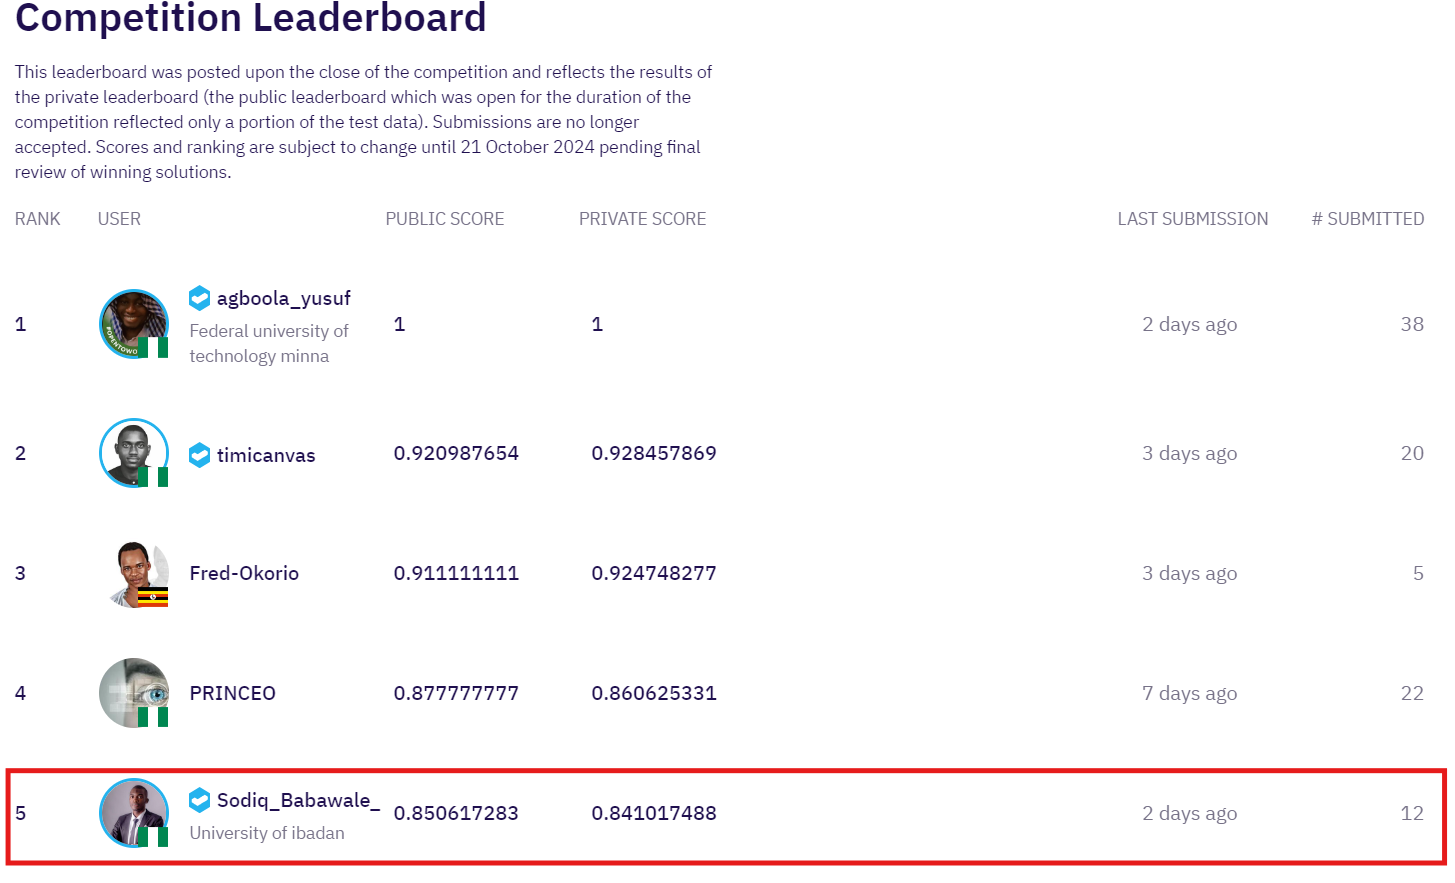